In [1]:
# defining the version of tensor flow
%tensorflow_version 2.x

# importing the modules to be used
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras import regularizers
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from google.colab import files
import itertools
import time

In [2]:
# download modules not in colab
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-yucj6nh2
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-yucj6nh2
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=1e8762b8c1c321f9af821a1ddee3b185788fbf759a11fbf2b8ed14e31be42cc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-_66oydo6/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


Preparing Data

In [3]:
# uploading data
datasets = files.upload()

Saving x1.csv to x1.csv
Saving x2.csv to x2.csv
Saving y1.csv to y1.csv
Saving y2.csv to y2.csv


In [4]:
# imorting data
x1 = pd.read_csv('x1.csv')
x2 = pd.read_csv('x2.csv')
y1 = pd.read_csv('y1.csv')
y2 = pd.read_csv('y2.csv')

sets = [x1, x2, y1, y2]

for i in sets:
  print(i.shape)

(7370, 45)
(1843, 45)
(7370, 1)
(1843, 1)


In [5]:
# standardizing Data
sc= StandardScaler()

X_train, X_test, y_train, y_test = [x.values for x in sets]

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Defining All Functions

In [6]:
#defining the function that builds the model

def model(actvFunc, nodes=1, layers=1, decrs= False):
  redcuc = 1
  if decrs:
    reduc = round(nodes / layers)
    nodes = [x for x in range(2, nodes+1, reduc)]
  else:
    nodes = [nodes] * layers

  nodes.reverse()
  
  
  ANN = tf.keras.models.Sequential()

  for n in nodes:
    ANN.add(tf.keras.layers.Dense(units= n, activation=actvFunc))

  ANN.add(tf.keras.layers.Dense(units= 1, activation=tf.keras.activations.linear))

  # compling ANN
  ANN.compile(loss = tf.keras.losses.mse, 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = ['mse'])
  
  return ANN

In [7]:
# function that finds all possible combinations given a set of lists
def product(lst):
    pools = [tuple(pool) for pool in lst]
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield list(prod)

In [8]:
# Grid search without K fold validation
def quickGridSearch(vals, model_func, Xin, Yin):
  all_combinations = list(product(vals))
  len(all_combinations)

  x_split = np.array_split(Xin, 5)
  y_split = np.array_split(Yin, 5)

  xval = x_split[0]
  yval = y_split[0]

  xtrn = np.concatenate([arr for arr in x_split if not np.array_equal(arr, x_split[0])])
  ytrn = np.concatenate([arr for arr in y_split if not np.array_equal(arr, y_split[0])])

  resDF = pd.DataFrame()
  done = 0
  for combo in all_combinations:
    start = time.time()
    ann = model_func(combo[0], combo[1], combo[2], combo[3])
    ann.fit(xtrn, ytrn, batch_size = 50, epochs= 130, verbose=0)
    end = round((time.time() - start)/60, 2)
    prd_y = ann.predict(xval)
    mse = mean_absolute_error(yval, prd_y)
    v = {'AcFunc1': combo[0], 'nodes': combo[1], 'layers': combo[2], 'decrs': combo[3], 'mse':mse, 'time': end}
    resDF = resDF.append(v, ignore_index=True)
    done = done + 1
    print(done, '/', len(all_combinations), end)

  return resDF

In [9]:
# Grid search with K fold validation
def kFoldGridSearch(vals, model_func, Xin, Yin, k):

  all_combinations = list(product(vals))

  x_split = np.array_split(Xin, k)
  y_split = np.array_split(Yin, k)
  resDF = pd.DataFrame()
  done = 0

  for combo in all_combinations:
    mse = []
    
    for i in range(k):
      xval = x_split[i]
      yval = y_split[i]

      xtrn = np.concatenate([arr for arr in x_split if not np.array_equal(arr, x_split[i])])
      ytrn = np.concatenate([arr for arr in y_split if not np.array_equal(arr, y_split[i])])
      
      start = time.time()
      ann = model_func(combo[0], combo[1], combo[2], combo[3])
      ann.fit(xtrn, ytrn, batch_size = 50, epochs= 130, verbose=0)
      end = round((time.time() - start)/60, 2)

      prd_y = ann.predict(xval)
      mse.append(mean_absolute_error(yval, prd_y))

      done = done + 1
      print(done, '/', len(all_combinations) * k, end)

    v = {'AcFunc': combo[0], 'nodes': combo[1], 'layers': combo[2], 'decrs': combo[3], 'mse':sum(mse) /len(mse), 'time': end}
    resDF = resDF.append(v, ignore_index=True)
    

  return resDF

In [10]:
# function that finds mean absolute error
def mae(yt, yp):
  yt = np.absolute(yt)
  yp = np.absolute(yp)
  diffs = []
  for i in range(len(yt)):
    v = sorted([yp[i], yt[i]])
    diffs.append(v[1] - v[0])
  return np.average(diffs)


In [11]:
# function that finds how many predictions were within the error margin
def errMrginAcc(p, y):
  perc = 10

  yes = []
  no = []
  
  for i in range(len(y)):

    margin = np.abs(y[i] / perc)
    upper = y[i] + margin
    lower = y[i] - margin

    if p[i] > lower and p[i] < upper:
      yes.append(y[i])
    else:
      no.append(y[i])

  return [len(yes)/len(y), yes, no]


In [12]:
# function that produces a summarized df of gridsearch
def descDF(resDF, params):
  bestDF = pd.DataFrame()

  for p in params:
    p_vals = list(resDF[p].unique())

    for v in p_vals:
      arr = np.array(resDF[resDF[p] == v]['mse'].values)
      mean = np.mean(arr)
      res = {'param': p, 'value': v, 'mean': mean}
      bestDF = bestDF.append(res, ignore_index=True)

  bestDF
  return bestDF

In [13]:
# function used to find model with lowest mae in grid search
def get_Min(df, col):
  return df[df[col] == df[col].min()]

Hyperparameter Discovery

In [ ]:
# search for hyper parameters
vals = [[tf.keras.activations.gelu], #[ tf.keras.activations.selu, tf.keras.activations.gelu],
        [60, 61, 62, 63, 70, 71, 72, 73], #[x for x in range(60, 85, 6)],
        [13], 
        [False]]

k = 4

gs = kFoldGridSearch(vals, model, X_train, y_train, k)

In [17]:
#download gs results
name = 'Model1_Run6.csv'
gs.to_csv(name, index=False)
files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GS Results

In [ ]:
params = ['AcFunc', 'nodes', 'layers', 'decrs']
desc = descDF(gs, params)
desc

In [ ]:
get_Min(gs, 'mse')

Compare All GS


In [14]:
# upload all gs results
datasets = files.upload()

Saving Model1_Run1.csv to Model1_Run1.csv
Saving Model1_Run2.csv to Model1_Run2.csv
Saving Model1_Run3.csv to Model1_Run3.csv
Saving Model1_Run4.csv to Model1_Run4.csv
Saving Model1_Run5.csv to Model1_Run5.csv
Saving Model1_Run6.csv to Model1_Run6.csv


In [15]:
# foramt all gs results into one df and summarize results
names = ['Model1_Run{}.csv'.format(s) for s in range(1, 7, 1)]

all = pd.DataFrame()
for n in names:
  all = pd.concat([all, pd.read_csv(n)], axis=0)

params = ['nodes', 'layers']
desc = descDF(all, params)

desc.sort_values(by=['value'], inplace=True)

desc

,param,value,mean
32,layers,2.0,0.933593
33,layers,4.0,0.399685
34,layers,6.0,0.366724
35,layers,8.0,0.281630
36,layers,10.0,0.377846
40,layers,11.0,0.163600
0,nodes,12.0,0.614917
37,layers,12.0,0.254280
41,layers,13.0,0.174125
38,layers,14.0,0.867012


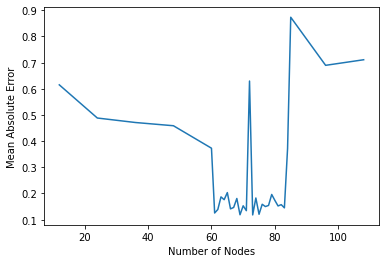

In [26]:
# graph mean mae to nodes
v = desc[desc['param'] == 'nodes']['value']
m = desc[desc['param'] == 'nodes']['mean']

plt.plot(v, m)
plt.xlabel('Number of Nodes')
plt.ylabel('Mean Absolute Error')
plt.show()

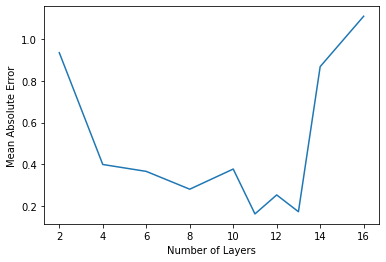

In [25]:
# graph mean mae to layers
v = desc[desc['param'] == 'layers']['value']
m = desc[desc['param'] == 'layers']['mean']

plt.plot(v, m)
plt.xlabel('Number of Layers')
plt.ylabel('Mean Absolute Error')
plt.show()

In [18]:
# split test and val data
testx = X_test[round(len(X_test)/3):]
valix = X_test[:round(len(X_test)/3):]
testy = y_test[round(len(y_test)/3):]
valiy = y_test[:round(len(y_test)/3)]

In [23]:
#  train ann
ann = model(tf.keras.activations.gelu, 84, 14, False)
size_histories = {}

size_histories['model'] = ann.fit(X_train, y_train, batch_size = 50, epochs= 130, verbose=0) #validation_data=(valix, valiy) add this arg to fit to get validation results

(0.0, 0.8)

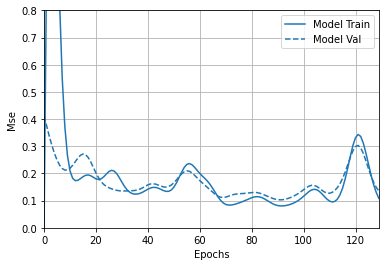

In [20]:
# checking for overfitting
plotter = tfdocs.plots.HistoryPlotter(metric = 'mse', smoothing_std=10)
plotter.plot(size_histories)
plt.plot(range(0, 130, 1), )
plt.ylim([0,0.8])

0.1508126536413432
0.667932718393923


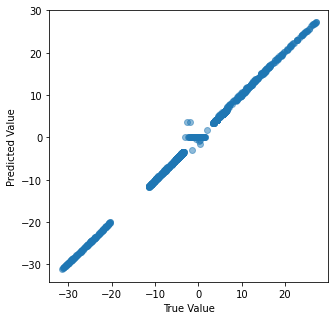

In [24]:
# show results
prd_y = ann.predict(X_test)
print(mean_absolute_error(y_test, prd_y))
print(errMrginAcc(prd_y, y_test)[0])

plt.figure(figsize=(5, 5))
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.scatter(y_test, prd_y, alpha = 0.5)